In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os, sys


import torch, torchvision
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import itertools
import numpy as np
import pandas as pd
import cv2
import random
import matplotlib.pyplot as plt
import urllib
import PIL.Image as Image
from tqdm import tqdm
from matplotlib.pyplot import imshow as cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

In [3]:
plt.rcParams['figure.figsize'] = [20, 16]

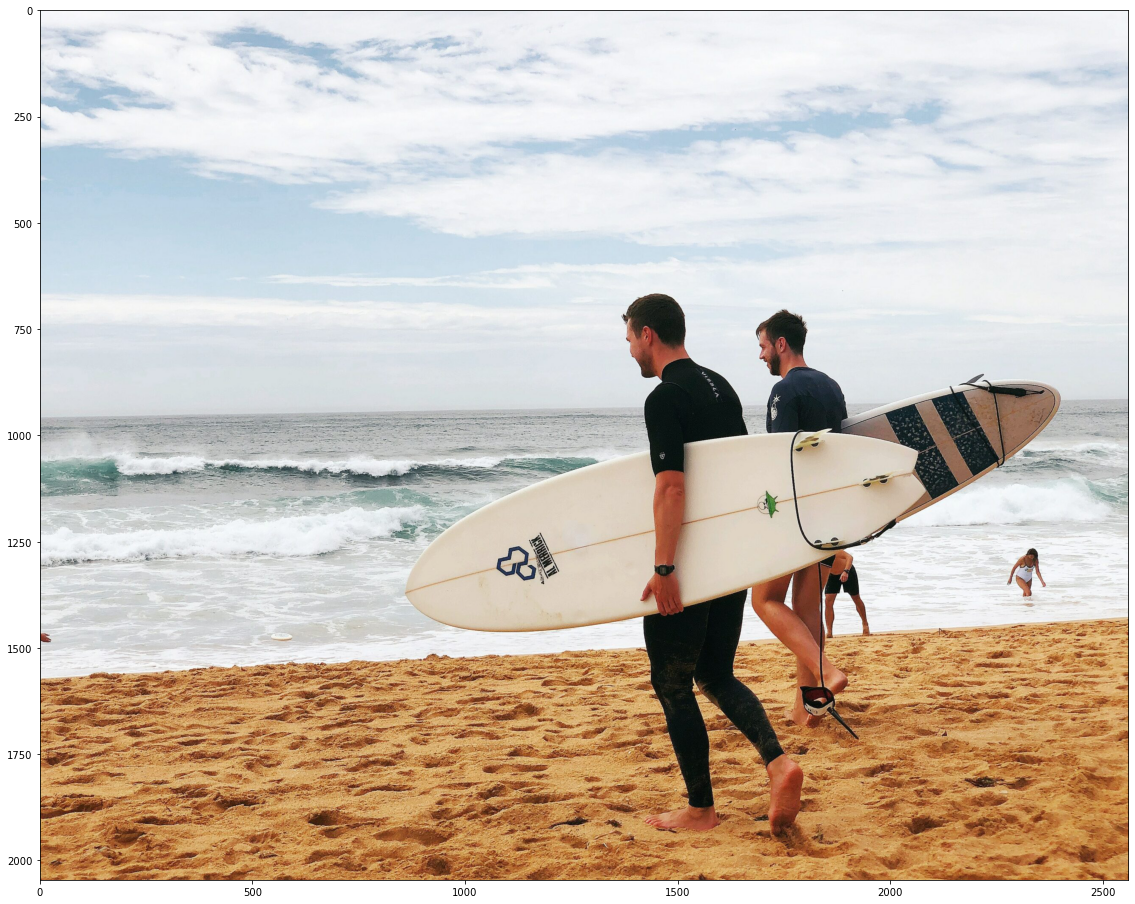

In [4]:

im = cv2.imread('../images/two-men-carrying-surfboards-near-seashore-1667018-scaled.jpg')
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
cv2_imshow(im)

In [11]:
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(im)

In [12]:
outputs["instances"].pred_classes
outputs["instances"].pred_boxes

Boxes(tensor([[ 852.1224,  986.9314, 2123.0017, 1453.2225],
        [1371.2357,  673.7845, 1818.6077, 1965.5629],
        [2274.6677, 1265.8834, 2364.4858, 1384.7963],
        [1662.4661,  701.7743, 1925.9419, 1701.6849],
        [1666.2905, 1274.0885, 1930.7904, 1723.6505],
        [1680.5414,  702.0171, 1895.8130, 1001.6780],
        [1833.9463, 1273.2512, 1950.9113, 1477.4473],
        [1791.8411,  867.5966, 2402.2476, 1282.1251]], device='cuda:0'))

In [17]:
outputs["instances"].pred_classes

tensor([37,  0,  0,  0,  0,  0,  0, 37], device='cuda:0')

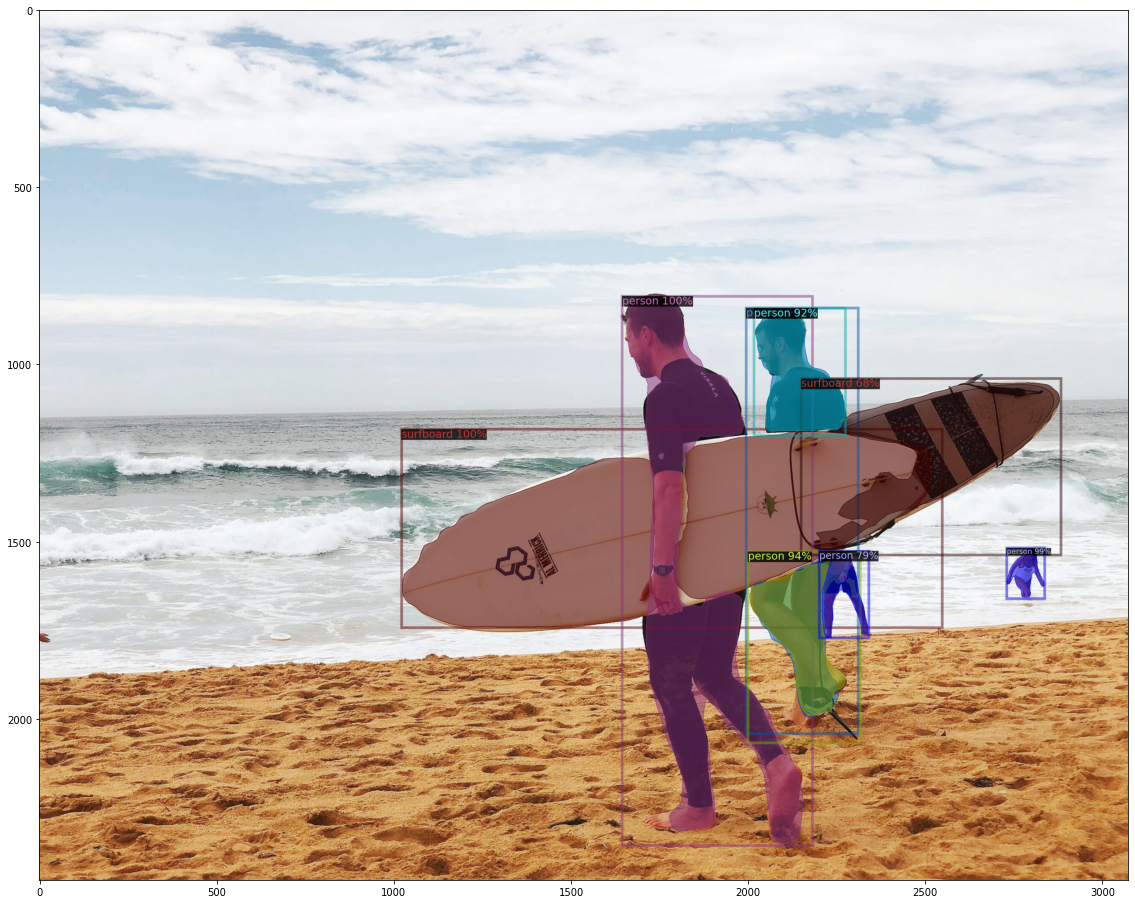

In [16]:
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(v.get_image()[:, :, ::-1])

### Train on Custom Set
Try adding a class using a faces dataset found on Kaggle.

In [30]:
IMAGES_PATH = f'../images/faces'
df_annot = pd.read_csv('../images/faces/annotations.csv')

In [31]:
faces = pd.read_json('../images/face_detection.json', lines=True)
faces.head()

content  \
0  http://com.dataturks.a96-i23.open.s3.amazonaws...   
1  http://com.dataturks.a96-i23.open.s3.amazonaws...   
2  http://com.dataturks.a96-i23.open.s3.amazonaws...   
3  http://com.dataturks.a96-i23.open.s3.amazonaws...   
4  http://com.dataturks.a96-i23.open.s3.amazonaws...   

                                          annotation  extras  
0  [{'label': ['Face'], 'notes': '', 'points': [{...     NaN  
1  [{'label': ['Face'], 'notes': '', 'points': [{...     NaN  
2  [{'label': ['Face'], 'notes': '', 'points': [{...     NaN  
3  [{'label': ['Face'], 'notes': '', 'points': [{...     NaN  
4  [{'label': ['Face'], 'notes': '', 'points': [{...     NaN

In [10]:
os.makedirs('../images/faces', exist_ok=True)

dataset = []

for index, row in tqdm(faces.iterrows(), total=faces.shape[0]):
    img = urllib.request.urlopen(row["content"])
    img = Image.open(img)
    img = img.convert('RGB')

    image_name = f'face_{index}.jpeg'

    img.save(f'../images/faces/{image_name}', "JPEG")

    annotations = row['annotation']
    for an in annotations:

        data = {}

        width = an['imageWidth']
        height = an['imageHeight']
        points = an['points']
  
        data['file_name'] = image_name
        data['width'] = width
        data['height'] = height

        data["x_min"] = int(round(points[0]["x"] * width))
        data["y_min"] = int(round(points[0]["y"] * height))
        data["x_max"] = int(round(points[1]["x"] * width))
        data["y_max"] = int(round(points[1]["y"] * height))

        data['class_name'] = 'face'

        dataset.append(data)

100%|██████████| 409/409 [03:35<00:00,  1.90it/s]


In [29]:
df_annot = pd.DataFrame(dataset)
df_annot.head()

NameError: name 'dataset' is not defined

In [12]:
df_annot.to_csv('../images/faces/annotations.csv', header=True, index=None)

In [32]:
def annotate_image(annotations, resize=True):
  file_name = annotations.file_name.to_numpy()[0]
  img = cv2.cvtColor(cv2.imread(f'../images/faces/{file_name}'), cv2.COLOR_BGR2RGB)

  for i, a in annotations.iterrows():
    cv2.rectangle(img, (a.x_min, a.y_min), (a.x_max, a.y_max), (0, 255, 0), 2)

  if not resize:
    return img

  return cv2.resize(img, (384, 384), interpolation = cv2.INTER_AREA)

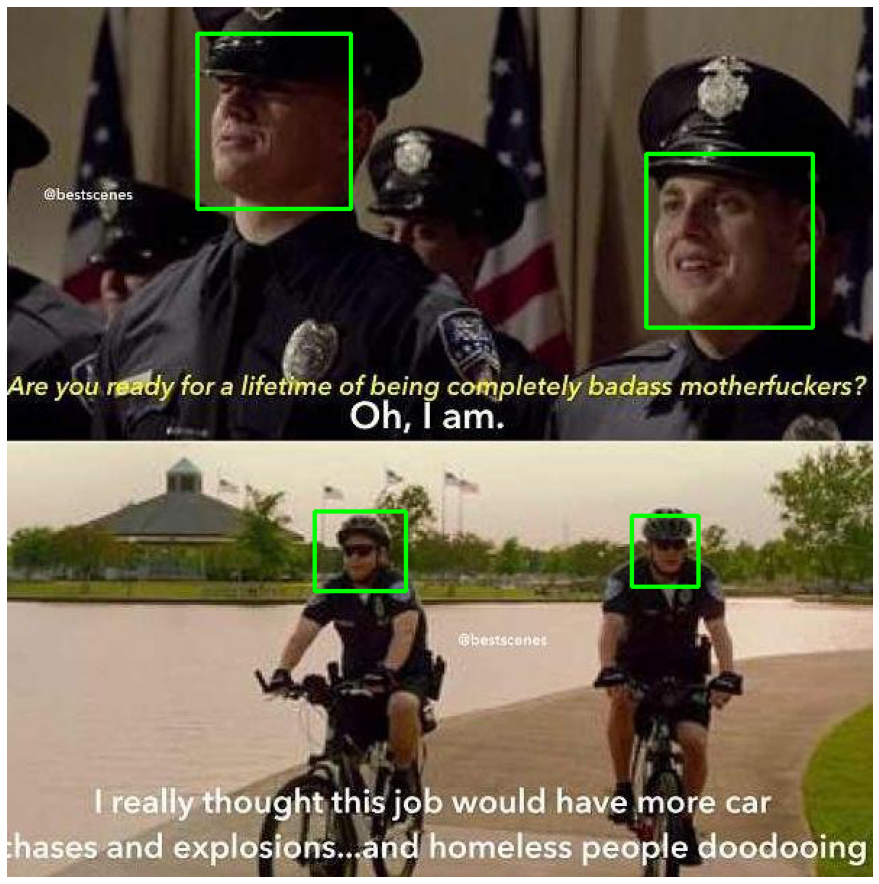

In [35]:
rand_ind = np.random.randint(409)
img_df = df_annot[df_annot.file_name == df_annot.file_name.unique()[rand_ind]]
img = annotate_image(img_df, resize=False)

plt.imshow(img)
plt.axis('off');

# Retrain the Model

In [6]:
IMAGES_PATH = f'../images/faces'
df_annot = pd.read_csv('../images/faces/annotations.csv')

uniq_files = df_annot.file_name.unique()
train_files = set(np.random.choice(uniq_files, int(len(uniq_files) * 0.95), replace=False))
train_df = df_annot[df_annot.file_name.isin(train_files)]
test_df = df_annot[~df_annot.file_name.isin(train_files)]

In [7]:
classes = df_annot.class_name.unique().tolist()
classes

['face']

In [8]:
test_df.head()

file_name  width  height  x_min  y_min  x_max  y_max class_name
105  face_41.jpeg    516     340    361    123    435    192       face
155  face_59.jpeg    800     533    559    130    717    298       face
156  face_59.jpeg    800     533    348    116    537    320       face
157  face_59.jpeg    800     533    156    138    335    378       face
193  face_74.jpeg    760     507    132    163    185    237       face

In [9]:
def create_dataset_dicts(df, classes):
  dataset_dicts = []
  for image_id, img_name in enumerate(df.file_name.unique()):

    record = {}

    image_df = df[df.file_name == img_name]

    file_path = f'{IMAGES_PATH}/{img_name}'
    record["file_name"] = file_path
    record["image_id"] = image_id
    record["height"] = int(image_df.iloc[0].height)
    record["width"] = int(image_df.iloc[0].width)

    objs = []
    for _, row in image_df.iterrows():

      xmin = int(row.x_min)
      ymin = int(row.y_min)
      xmax = int(row.x_max)
      ymax = int(row.y_max)

      poly = [
          (xmin, ymin), (xmax, ymin),
          (xmax, ymax), (xmin, ymax)
      ]
      poly = list(itertools.chain.from_iterable(poly))

      obj = {
        "bbox": [xmin, ymin, xmax, ymax],
        "bbox_mode": BoxMode.XYXY_ABS,
        "segmentation": [poly],
        "category_id": classes.index(row.class_name),
        "iscrowd": 0
      }
      objs.append(obj)

    record["annotations"] = objs
    dataset_dicts.append(record)
  return dataset_dicts

In [10]:
for d in ["train", "val"]:
  DatasetCatalog.register("faces_" + d, lambda d=d: create_dataset_dicts(train_df if d == "train" else test_df, classes))
  MetadataCatalog.get("faces_" + d).set(thing_classes=classes)

statement_metadata = MetadataCatalog.get("faces_train")

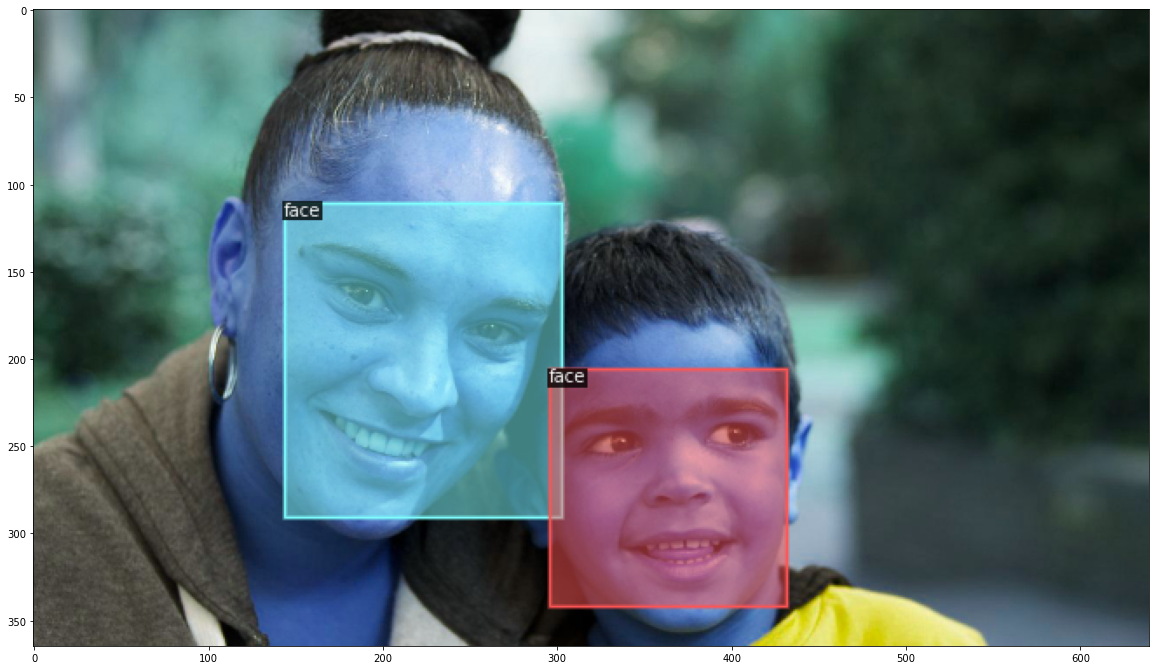

In [11]:
dataset_dicts = create_dataset_dicts(train_df, classes)
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=statement_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

In [12]:
class CocoTrainer(DefaultTrainer):

  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):

    if output_folder is None:
        os.makedirs("coco_eval", exist_ok=True)
        output_folder = "coco_eval"

    return COCOEvaluator(dataset_name, cfg, False, output_folder)

In [13]:
cfg = get_cfg()
cfg.merge_from_file(
  model_zoo.get_config_file(
    "COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml"
  )
)

cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(
  "COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml"
)
cfg.DATASETS.TRAIN = ("faces_train",)
cfg.DATASETS.TEST = ("faces_val",)
cfg.DATALOADER.NUM_WORKERS = 4
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.001
cfg.SOLVER.WARMUP_ITERS = 1000
cfg.SOLVER.MAX_ITER = 1500
cfg.SOLVER.STEPS = (1000, 1500)
cfg.SOLVER.GAMMA = 0.05
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 32
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(classes)
cfg.TEST.EVAL_PERIOD = 500

In [14]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = CocoTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[05/03 13:07:44 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

RuntimeError: CUDA out of memory. Tried to allocate 242.00 MiB (GPU 0; 7.79 GiB total capacity; 2.70 GiB already allocated; 123.62 MiB free; 3.06 GiB reserved in total by PyTorch)

In [ ]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

### Panoptic Segmentation Model

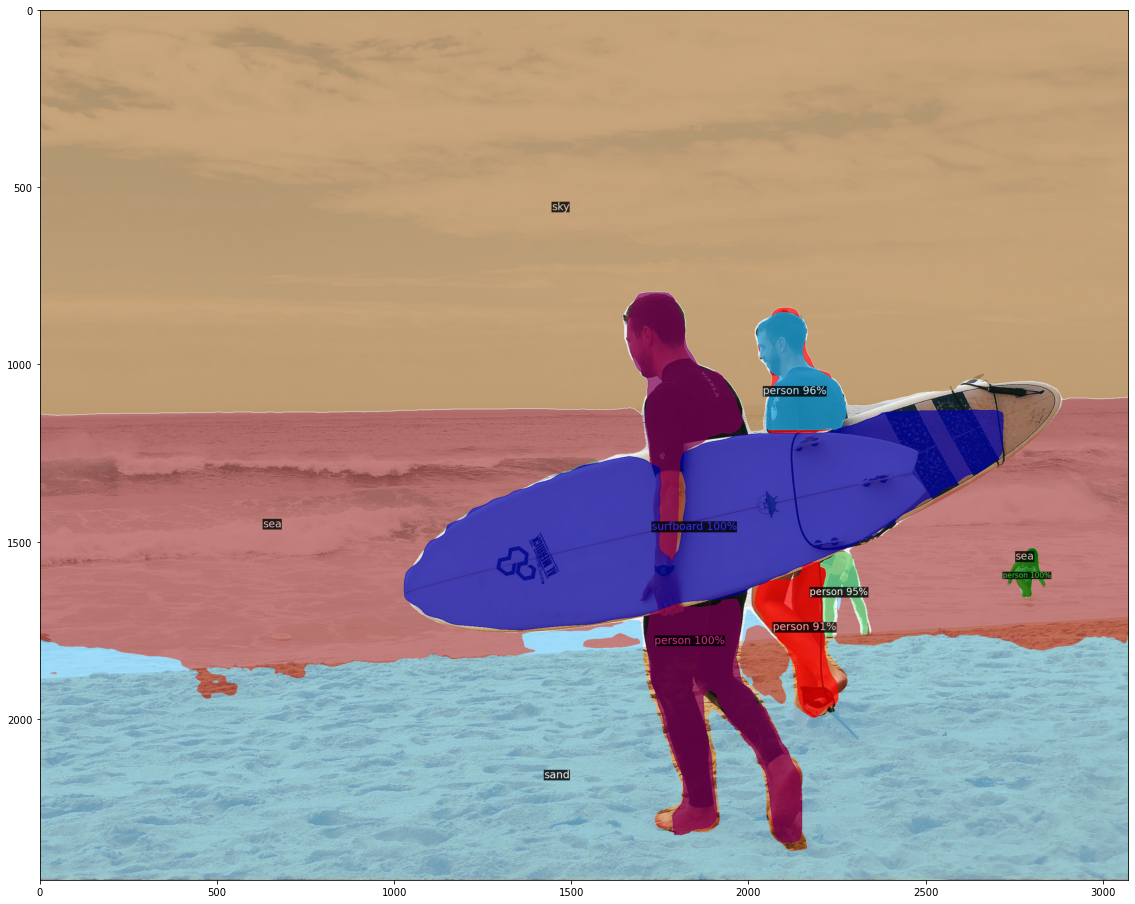

In [5]:
# Inference with a panoptic segmentation model
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml")
predictor = DefaultPredictor(cfg)
panoptic_seg, segments_info = predictor(im)["panoptic_seg"]
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_panoptic_seg_predictions(panoptic_seg.to("cpu"), segments_info)
cv2_imshow(v.get_image()[:, :, ::-1])